In [ ]:
from typing import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
import tqdm


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

from sklearn.preprocessing import LabelEncoder
torch.manual_seed(42)

In [ ]:

class PlantDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.dataframe["encoded_label"] = self.label_encoder.fit_transform(self.dataframe.iloc[:, 1])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]["image_path"]
        image = Image.open(image_path).convert("RGB")

        label = self.dataframe.iloc[idx]["encoded_label"]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [ ]:
train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
test = pd.read_csv("data/test.csv")

train_dataset = PlantDataset(dataframe=train, image_dir="inaturalist", transform=transform)
val_dataset = PlantDataset(dataframe=val, image_dir="inaturalist", transform=transform)
test_dataset = PlantDataset(dataframe=test, image_dir="inaturalist", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




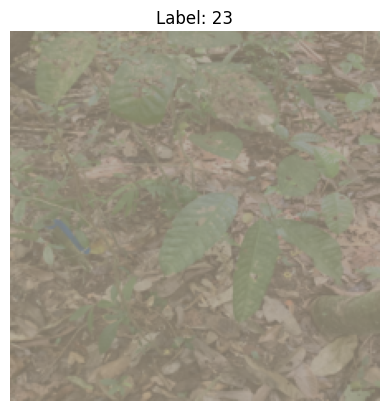

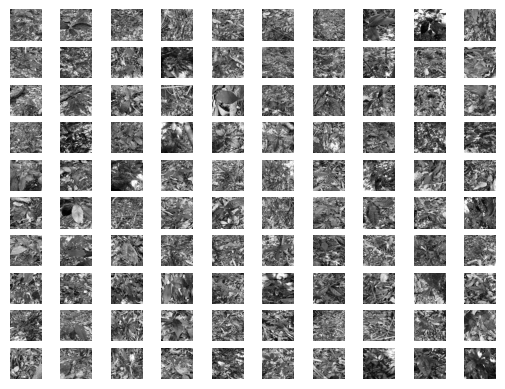

In [ ]:
image, label = train_dataset[0]

image = image.permute(1, 2, 0).numpy()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    plt.axis('off')

In [ ]:
from typing import Tuple
import random
from PIL import ImageFilter
import torchvision.transforms as tfs


class SingleInstanceTwoView:

    def __init__(self, imsize: int, mean: Tuple[float], std: Tuple[float]):

        self.augmentation = tfs.Compose([
            tfs.Resize(imsize),
            tfs.RandomResizedCrop(imsize, scale=(0.8, 1.2)),
            tfs.RandomHorizontalFlip(0.5),
            tfs.RandomApply([tfs.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p =0.4),
            tfs.RandomGrayscale(p=0.2),
            tfs.RandomApply([GaussianBlur(sigma=(0.1, 2))], p=0.5),
            tfs.ToTensor(),
            tfs.Normalize(mean=mean, std=std)
        ])

    def __call__(self, x):
        aug1 = self.augmentation(x)
        aug2 = self.augmentation(x)
        return aug1, aug2


class GaussianBlur(object):

    def __init__(self, sigma=[0.1, 1.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(1024 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(1024 * 7 * 7, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 1024 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        x_encoded = self.encoder(x)
        x_encoded_flat = x_encoded.view(batch_size, -1)
        mu = self.fc_mu(x_encoded_flat)
        logvar = self.fc_logvar(x_encoded_flat)
        z = self.reparameterize(mu, logvar)
        decoder_input = self.decoder_input(z)
        decoder_input = decoder_input.view(batch_size, 1024, 7, 7)
        x_recon = self.decoder(decoder_input)
        return x_recon, mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train_vae(X_train, learning_rate=1e-3, num_epochs=10, batch_size=32):
    X_train = torch.from_numpy(X_train).to(device)

    model = ConvVAE()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss(reduction="sum")

    model.to(device)

    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)

            encoded, decoded, mu, log_var = model(data)

            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(decoded, data) + 3 * KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)

        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

    return model

In [26]:

import matplotlib.pyplot as plt

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)
        optimizer.zero_grad()

        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")


Epoch [1/20] Average Loss: 2444147.5139


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, _ = batch
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        break

images = images.cpu().numpy()
recon_images = recon_images.cpu().numpy()

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i].transpose(1, 2, 0))
    plt.title("Reconstruction")
    plt.axis("off")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, model.latent_dim).to(device)
    decoder_input = model.decoder_input(z)
    decoder_input = decoder_input.view(-1, 1024, 7, 7)
    generated_images = model.decoder(decoder_input)

generated_images = generated_images.cpu().numpy()
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].transpose(1, 2, 0))
    plt.axis("off")
plt.show()